Problem Statement:

In this challenge, participants will develop a predictive model capable of forecasting traffic volume at specific times, given various influential factors within the dataset.

Evaluation Metric:

The hackathon evaluation will be based on the Root Mean Squared Error (RMSE) metric.

In [2]:
import pandas as pd   # importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
# using both the files of train and test data to predict simultaneously
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")  # Using this for prediction later

EDA - EXPLORATORY DATA ANALYSIS

In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             50 non-null     float64
 1   Temperature         38373 non-null  float64
 2   Rainfall_last_hour  38373 non-null  float64
 3   Snowfall_last_hour  38373 non-null  float64
 4   Cloud_Cover         38373 non-null  int64  
 5   Weather             38373 non-null  object 
 6   Weather_Desc        38373 non-null  object 
 7   TimeStamp           38373 non-null  object 
 8   Date                38373 non-null  object 
 9   Traffic_Vol         38373 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 2.9+ MB
None


In [ ]:
print(train_data.describe())

       Holiday   Temperature  Rainfall_last_hour  Snowfall_last_hour  \
count     50.0  38373.000000        38373.000000        38373.000000   
mean       1.0    281.152767            0.327486            0.000128   
std        0.0     13.813324           50.194024            0.005924   
min        1.0      0.300000            0.000000            0.000000   
25%        1.0    271.910000            0.000000            0.000000   
50%        1.0    281.990000            0.000000            0.000000   
75%        1.0    292.140000            0.000000            0.000000   
max        1.0    310.970000         9831.414286            0.512857   

        Cloud_Cover   Traffic_Vol  
count  38373.000000  38373.000000  
mean      44.821098   3293.947567  
std       38.749566   1988.311540  
min        0.000000      4.000000  
25%        1.000000   1246.000000  
50%       40.000000   3425.000000  
75%       90.000000   4964.000000  
max      101.000000   7289.000000  


The reason print(train_data.describe()) does not include Weather, Weather_Desc, TimeStamp, and Date is that describe() only works on numerical columns by default.

To include them use following : include all command

In [ ]:
print(train_data.describe(include='all'))

        Holiday   Temperature  Rainfall_last_hour  Snowfall_last_hour  \
count      50.0  38373.000000        38373.000000        38373.000000   
unique      NaN           NaN                 NaN                 NaN   
top         NaN           NaN                 NaN                 NaN   
freq        NaN           NaN                 NaN                 NaN   
mean        1.0    281.152767            0.327486            0.000128   
std         0.0     13.813324           50.194024            0.005924   
min         1.0      0.300000            0.000000            0.000000   
25%         1.0    271.910000            0.000000            0.000000   
50%         1.0    281.990000            0.000000            0.000000   
75%         1.0    292.140000            0.000000            0.000000   
max         1.0    310.970000         9831.414286            0.512857   

         Cloud_Cover       Weather Weather_Desc      TimeStamp      Date  \
count   38373.000000         38373        38373

In [ ]:
print(train_data.isnull().sum())

Holiday               38323
Temperature               0
Rainfall_last_hour        0
Snowfall_last_hour        0
Cloud_Cover               0
Weather                   0
Weather_Desc              0
TimeStamp                 0
Date                      0
Traffic_Vol               0
dtype: int64


No null values are present in Train Data

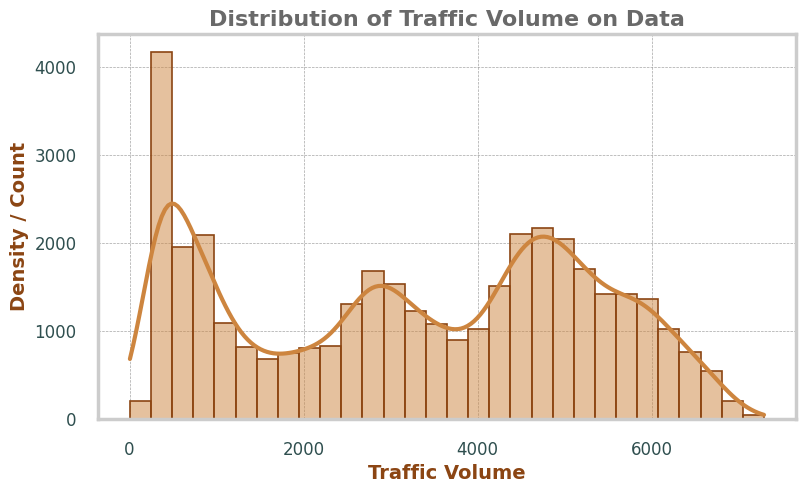

In [ ]:
sns.set_style('whitegrid')
sns.set_context('poster')

plt.figure(figsize=(9, 5))
sns.histplot(train_data['Traffic_Vol'],
             bins=30,
             kde=True,
             color='peru',  # Custom color
             edgecolor='saddlebrown',  # Add edge color to bins
             linewidth=1.2)  # Width of the edge lines

plt.title("Distribution of Traffic Volume on Data", fontsize=16, fontweight='bold', color='dimgrey')
plt.xlabel('Traffic Volume', fontsize=14, fontweight='bold', color='saddlebrown')
plt.ylabel('Density / Count', fontsize=14, fontweight='bold', color='saddlebrown')

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, color='darkslategrey')  # Customize x-axis tick labels
plt.yticks(fontsize=12, color='darkslategrey')  # Customize y-axis tick labels

plt.show()

Column 'TimeStamp' not found in the dataset. Skipping timestamp processing.
Column 'Weather_Desc' not found. Skipping one-hot encoding.


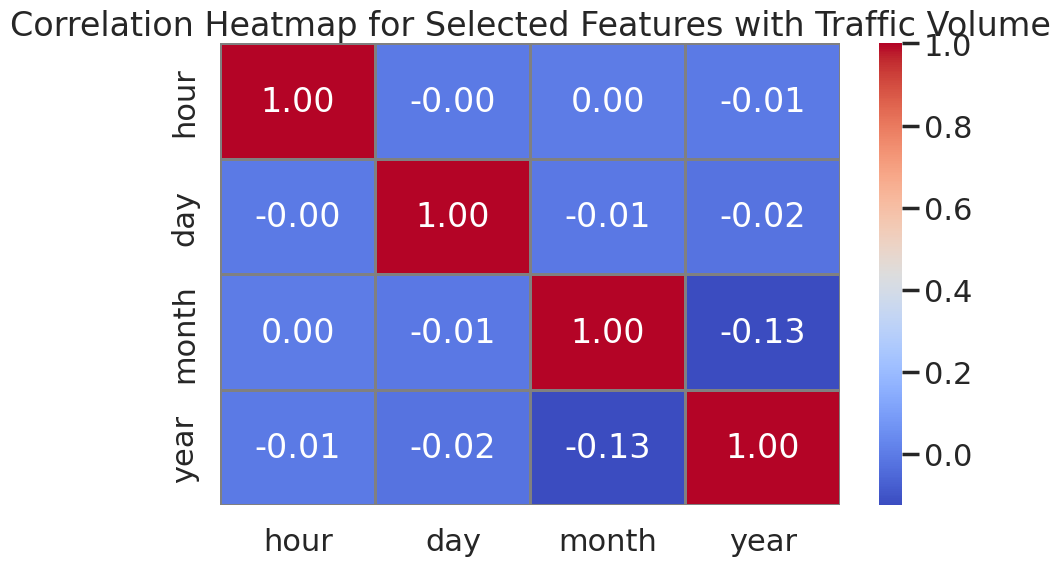

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   holiday                                           50 non-null     float64
 1   temperature                                       38373 non-null  float64
 2   rainfall_last_hour                                38373 non-null  float64
 3   snowfall_last_hour                                38373 non-null  float64
 4   cloud_cover                                       38373 non-null  int64  
 5   traffic_vol                                       38373 non-null  int64  
 6   hour                                              38373 non-null  int32  
 7   day                                               38373 non-null  int32  
 8   month                                             38373 non-null  int32  
 9   year             

In [ ]:
# correlation map
if 'TimeStamp' in train_data.columns:
    train_data['TimeStamp'] = pd.to_datetime(train_data['TimeStamp'], errors='coerce')
    train_data['Hour'] = train_data['TimeStamp'].dt.hour
    train_data['Day'] = train_data['TimeStamp'].dt.day
    train_data['Month'] = train_data['TimeStamp'].dt.month
    train_data['Year'] = train_data['TimeStamp'].dt.year
    train_data.drop(columns=['TimeStamp'], inplace=True)
else:
    print("Column 'TimeStamp' not found in the dataset. Skipping timestamp processing.")

if 'Weather_Desc' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=['Weather_Desc'], drop_first=True)
else:
    print("Column 'Weather_Desc' not found. Skipping one-hot encoding.")

non_numeric_cols = train_data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found: {non_numeric_cols}")
    train_data.drop(columns=non_numeric_cols, inplace=True)

columns_of_interest = ['traffic_volume', 'hour', 'day', 'month', 'year', 'temp', 'humidity', 'wind_speed']

columns_of_interest = [col for col in columns_of_interest if col in train_data.columns]

correlation = train_data[columns_of_interest].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("Correlation Heatmap for Selected Features with Traffic Volume")
plt.show()

print(train_data.info())

Interpretation :
 This heatmap shows that the selected time-based features do not have strong relationships with each other except for themselves.

Columns in the dataset: Index(['holiday', 'temperature', 'rainfall_last_hour', 'snowfall_last_hour',
       'cloud_cover', 'traffic_vol', 'hour', 'day', 'month', 'year',
       'weather_desc_approaching_thunderstorm',
       'weather_desc_approaching_thunderstorm_with_rain',
       'weather_desc_clear_skies', 'weather_desc_deep_snow',
       'weather_desc_dense_fog', 'weather_desc_drizzle_mixed_with_snow',
       'weather_desc_fine_fog', 'weather_desc_flurries',
       'weather_desc_fragmented_clouds', 'weather_desc_full_cloud_cover',
       'weather_desc_gentle_rain_shower', 'weather_desc_ice_rain',
       'weather_desc_icy_rain', 'weather_desc_intense_rainfall',
       'weather_desc_light_rain', 'weather_desc_mild_drizzle',
       'weather_desc_nearby_rain_showers',
       'weather_desc_nearby_thunderstorm_with_light_rain',
       'weather_desc_partly_cloudy_skies', 'weather_desc_scattered_clouds',
       'weather_desc_scattered_snowflakes',
       'weather_desc_severe_storm_with_hea

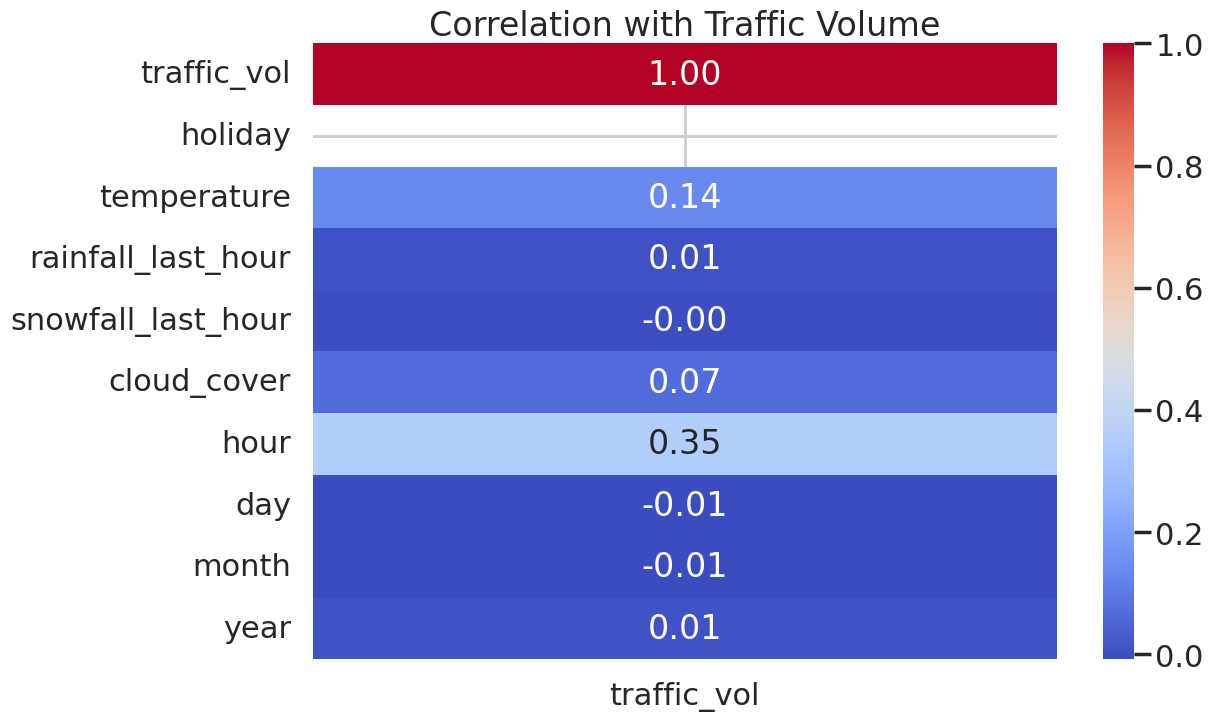

Correlation with Traffic_Vol:
                    traffic_vol
traffic_vol            1.000000
holiday                     NaN
temperature            0.137977
rainfall_last_hour     0.005540
snowfall_last_hour    -0.002285
cloud_cover            0.070310
hour                   0.354548
day                   -0.005872
month                 -0.008407
year                   0.009857


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns in the dataset:", train_data.columns)

columns_of_interest = ['traffic_vol', 'holiday', 'temperature', 'rainfall_last_hour',
                       'snowfall_last_hour', 'cloud_cover', 'hour', 'day', 'month', 'year']

missing_columns = [col for col in columns_of_interest if col not in train_data.columns]
if missing_columns:
    print(f"Missing columns in the DataFrame: {missing_columns}")
else:
    filtered_data = train_data[columns_of_interest]

    correlation = filtered_data.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation[['traffic_vol']], annot=True, cmap="coolwarm", fmt='.2f')
    plt.title("Correlation with Traffic Volume")
    plt.show()

    print("Correlation with Traffic_Vol:")
    print(correlation[['traffic_vol']])

In [ ]:
print(train_data.columns)


Index(['holiday', 'temperature', 'rainfall_last_hour', 'snowfall_last_hour',
       'cloud_cover', 'traffic_vol', 'hour', 'day', 'month', 'year',
       'weather_desc_approaching_thunderstorm',
       'weather_desc_approaching_thunderstorm_with_rain',
       'weather_desc_clear_skies', 'weather_desc_deep_snow',
       'weather_desc_dense_fog', 'weather_desc_drizzle_mixed_with_snow',
       'weather_desc_fine_fog', 'weather_desc_flurries',
       'weather_desc_fragmented_clouds', 'weather_desc_full_cloud_cover',
       'weather_desc_gentle_rain_shower', 'weather_desc_ice_rain',
       'weather_desc_icy_rain', 'weather_desc_intense_rainfall',
       'weather_desc_light_rain', 'weather_desc_mild_drizzle',
       'weather_desc_nearby_rain_showers',
       'weather_desc_nearby_thunderstorm_with_light_rain',
       'weather_desc_partly_cloudy_skies', 'weather_desc_scattered_clouds',
       'weather_desc_scattered_snowflakes',
       'weather_desc_severe_storm_with_heavy_rain', 'weather_desc_

Result 1 : The most relevant feature correlated with traffic volume in the dataset is 'hour', which shows a moderate positive correlation. This suggests that traffic volume may vary with the time of day.

The session crash due to out-of-memory (RAM overflow) indicates that the dataset might be large or the processing (like one-hot encoding and model training) is consuming excessive memory.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

target_column = 'Traffic_Vol'

X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X, _, y, _ = train_test_split(X, y, test_size=0.7, random_state=42)

non_numeric_cols = X.select_dtypes(include=['object']).columns

low_cardinality_cols = [col for col in non_numeric_cols if X[col].nunique() < 10]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(X[low_cardinality_cols]))
encoded_cols.columns = encoder.get_feature_names_out(low_cardinality_cols)


X_numeric = X.drop(non_numeric_cols, axis=1)
X_final = pd.concat([X_numeric.reset_index(drop=True), encoded_cols], axis=1)

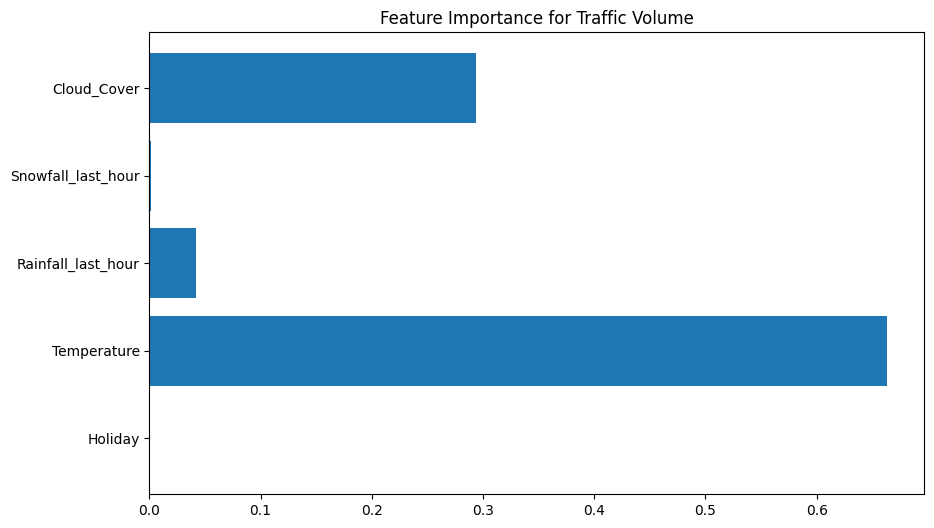

In [ ]:
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_final, y)

import matplotlib.pyplot as plt
importance = model.feature_importances_
features = X_final.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.title('Feature Importance for Traffic Volume')
plt.show()

Interpretation :
1. Temperature:

- High importance suggests that traffic volume has a strong relationship with temperature.

This could indicate:
- People tend to travel more in mild or favorable temperatures.
- Extreme temperatures (very hot or very cold) might reduce travel, especially for outdoor activities or errands.

In [ ]:
# submission file
import pandas as pd

columns_to_drop = ['Date', 'TimeStamp', 'Weather', 'Weather_Desc']
existing_columns = [col for col in columns_to_drop if col in test_data.columns]
if existing_columns:
    test_data = test_data.drop(columns=existing_columns, axis=1)
else:
    print("Columns to drop not found in test_data.")

if 'TimeStamp' in test_data.columns:
    test_data['TimeStamp'] = pd.to_datetime(test_data['TimeStamp'], errors='coerce')
    test_data['Hour'] = test_data['TimeStamp'].dt.hour
    test_data['Day'] = test_data['TimeStamp'].dt.day
    test_data['Month'] = test_data['TimeStamp'].dt.month
    test_data['Year'] = test_data['TimeStamp'].dt.year
    test_data.drop(columns=['TimeStamp'], inplace=True)

test_data = pd.get_dummies(test_data, columns=['Holiday'], drop_first=True, dummy_na=False)

missing_cols = set(X_final.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0

extra_cols = set(test_data.columns) - set(X_final.columns)
test_data = test_data.drop(columns=list(extra_cols))

test_data = test_data[X_final.columns]

predictions = model.predict(test_data)

submission = pd.DataFrame({
    'ID': test_data.index,
    'Traffic_Vol': predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Columns to drop not found in test_data.
Submission file saved as 'submission.csv'.


<ipython-input-8-aa4ce9d59965>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Hour'] = pd.to_datetime(X['TimeStamp']).dt.hour
<ipython-input-8-aa4ce9d59965>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['DayOfWeek'] = pd.to_datetime(X['Date']).dt.dayofweek
<ipython-input-8-aa4ce9d59965>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Month'] = pd.to_datetime(X['Date']).dt.month


Categorical Columns: Index(['Weather', 'Weather_Desc'], dtype='object')
R2 Score: 0.8509205854236921


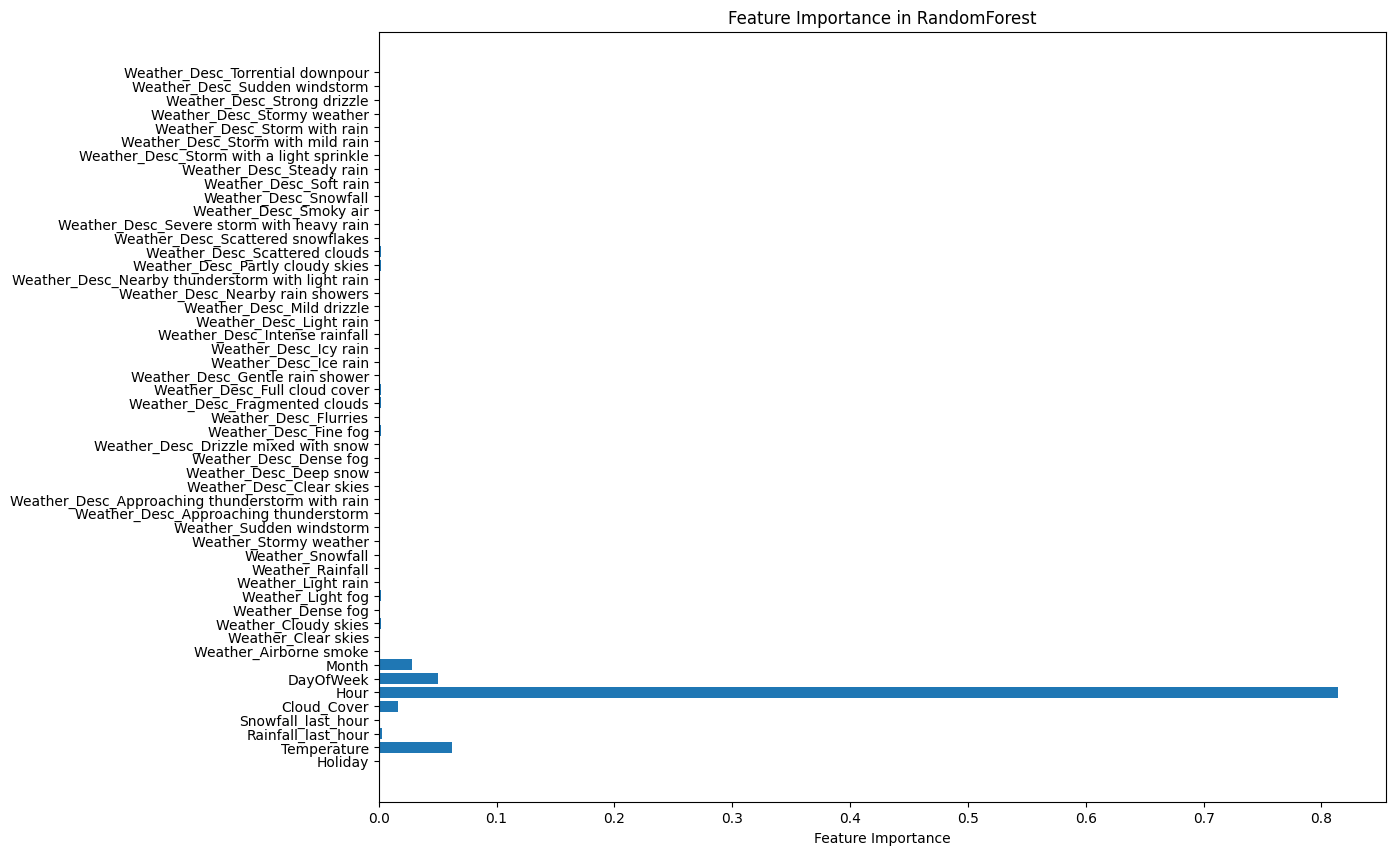

In [8]:
# RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from joblib import dump, load
import matplotlib.pyplot as plt

# Load your data (use a fraction to avoid crashing the session)
X = train_data.sample(frac=0.7, random_state=42)
y = X['Traffic_Vol']
X = X.drop('Traffic_Vol', axis=1)

# Step 1: Feature Engineering (Date and Time)
X['Hour'] = pd.to_datetime(X['TimeStamp']).dt.hour
X['DayOfWeek'] = pd.to_datetime(X['Date']).dt.dayofweek
X['Month'] = pd.to_datetime(X['Date']).dt.month

# Drop unnecessary features (already encoded into Hour, DayOfWeek, Month)
X = X.drop(['Date', 'TimeStamp'], axis=1)

# Identify categorical columns (automatically detects string columns)
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"Categorical Columns: {categorical_columns}")

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest with more trees and deeper depth
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
rf_reg.fit(X_train, y_train)

# Evaluate
y_pred = rf_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

# Save model
dump(rf_reg, 'rf_model.pkl')

# Feature Importance
importances = rf_reg.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(13, 10))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in RandomForest')
plt.show()


In [10]:
# Finding The Best hyperparameters
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from joblib import dump
import matplotlib.pyplot as plt

X = train_data.sample(frac=0.7, random_state=42)
y = X['Traffic_Vol']
X = X.drop('Traffic_Vol', axis=1)

# Feature Engineering
X['Hour'] = pd.to_datetime(X['TimeStamp']).dt.hour
X['DayOfWeek'] = pd.to_datetime(X['Date']).dt.dayofweek
X['Month'] = pd.to_datetime(X['Date']).dt.month

# Drop unnecessary features
X = X.drop(['Date', 'TimeStamp'], axis=1)

# One-hot encoding of categorical features
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter search space

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],       # Number of trees
    'max_depth': [5, 10, 20, 30, 40, 50, None],           # Maximum depth of tree
    'min_samples_split': [2, 5, 10],                     # Min samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],                   # Min samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']             # Features to consider when splitting
}

# RandomizedSearchCV setup
rf_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_grid,
    n_iter=50,                 # Number of random samples to try
    cv=5,                      # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,                 # Use all available cores
    random_state=42
)

# Fit the model on training data
random_search.fit(X_train, y_train)

# Show the best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Train the model using the best parameters
best_rf_reg = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score after hyperparameter tuning: {r2}")



<ipython-input-10-e1ec6705e443>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Hour'] = pd.to_datetime(X['TimeStamp']).dt.hour
<ipython-input-10-e1ec6705e443>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['DayOfWeek'] = pd.to_datetime(X['Date']).dt.dayofweek
<ipython-input-10-e1ec6705e443>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Month'] = pd.to_datetime(X['Date']).dt.month


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
R2 Score after hyperparameter tuning: 0.8587200045075072


In [14]:
import pandas as pd
from joblib import load

# Load your trained model (assumed to be saved earlier)
model = load('best_rf_model.pkl')

# Load the test data (use the correct path for your test data)
test_data = pd.read_csv('Test.csv')

# ----> Create 'ID' column if it doesn't exist <----
if 'ID' not in test_data.columns:
    test_data['ID'] = test_data.index

# Feature Engineering for the test data (same as training data)
test_data['Hour'] = pd.to_datetime(test_data['TimeStamp']).dt.hour
test_data['DayOfWeek'] = pd.to_datetime(test_data['Date']).dt.dayofweek
test_data['Month'] = pd.to_datetime(test_data['Date']).dt.month

# Drop unnecessary features and columns (same as done for training)
test_data = test_data.drop(['Date', 'TimeStamp'], axis=1)

# One-hot encode categorical features (same as training)
test_data = pd.get_dummies(test_data, drop_first=True)

# Get feature names from training data (assuming X_train was used during training)
feature_names = X_train.columns # Assuming X_train is available from your training code

# Ensure the test data has the same feature columns as the model expects
# Use feature_names instead of model.feature_importances_.index
X_test = test_data.reindex(columns=feature_names, fill_value=0)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Create the submission DataFrame (adjust column names based on competition requirements)
submission = pd.DataFrame({
    'ID': test_data['ID'],  # Assuming the test set has an 'ID' column
    'Traffic_Vol': test_predictions
})

# Save to CSV (ensure the correct column names are used)
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

<ipython-input-14-dd69853379d5>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['Hour'] = pd.to_datetime(test_data['TimeStamp']).dt.hour
<ipython-input-14-dd69853379d5>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['DayOfWeek'] = pd.to_datetime(test_data['Date']).dt.dayofweek
<ipython-input-14-dd69853379d5>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['Month'] = pd.to_datetime(test_data['Date']).dt.month


Submission file created: submission.csv
